In [1]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis")
print(os.getcwd())


E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\JRF\1_PAPER\2_Analysis


In [2]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
#import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


# 1. GRIDWISE

### 1. ALL

C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


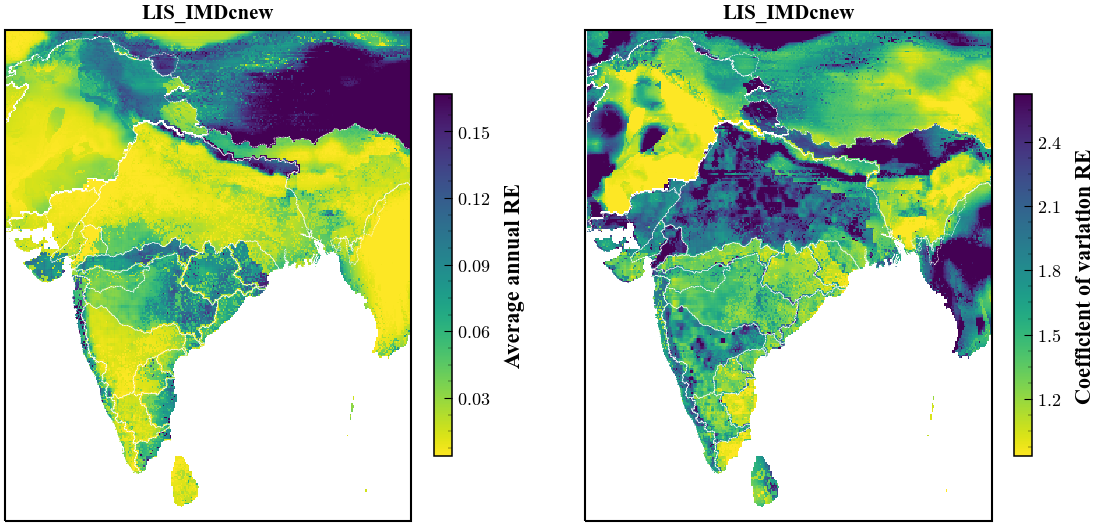

In [8]:
mdl=5
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc","LIS_IMDcnew"]
lsm_M = xr.open_mfdataset(f'DATA_p/LIS/{model[mdl]}/{model[mdl]}_grid_All.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})


fig, axs = plt.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,14*1.2),constrained_layout=False)
A=lsm_M["RE_cleaned"].mean(dim="time").compute()
B=lsm_M["RE_cleaned"].std(dim="time").compute()/lsm_M["RE_cleaned"].mean(dim="time").compute()

Map_plot1(A,fig,axs[0],model[mdl],"Average annual RE")
Map_plot1(B,fig,axs[1],model[mdl],"Coefficient of variation RE")
plt.savefig(f"2_RE analysis/1_mean_var/outputs/mn_vr_{model[mdl]}.jpeg", bbox_inches='tight')
plt.show()


### 1.2 Seasonal

c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


0.16503667481662593
0.16503667481662587
0.16503667481662593
0.16503667481662598
0.16503667481662593
0.16503667481662587
0.16503667481662593
0.16503667481662598


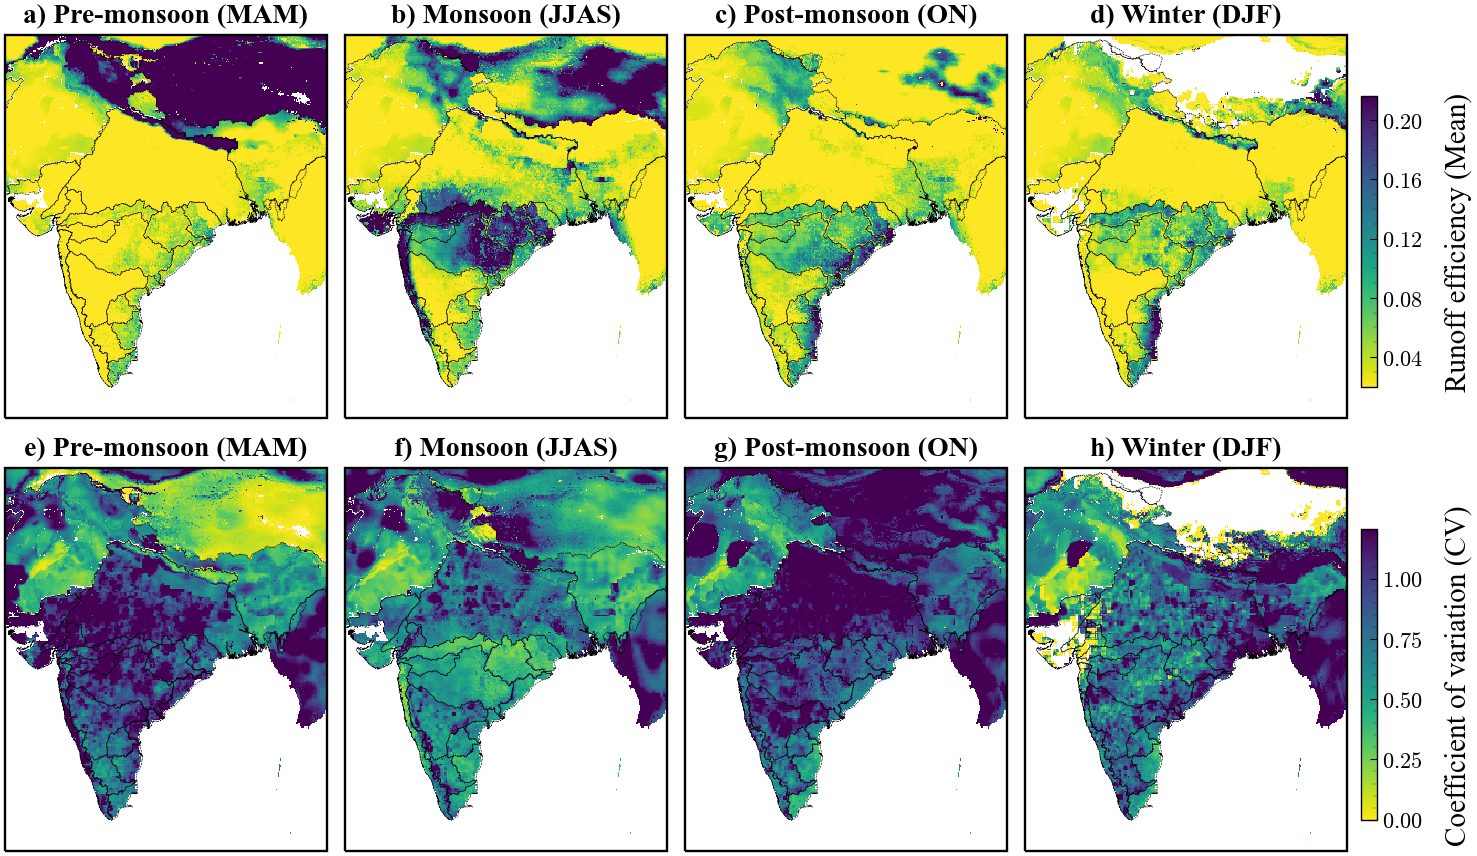

In [9]:
mdl=5
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc","LIS_IMDcnew"]
lsm_M = xr.open_mfdataset(f'DATA_p/LIS/{model[mdl]}/{model[mdl]}_grid_ssn.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})

mthd=['Runoff efficiency (Mean)','Coefficient of variation (CV)']
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_lb=['Pre-monsoon (MAM)','Monsoon (JJAS)','Post-monsoon (ON)','Winter (DJF)']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE','RE_cleaned']
result1=[]
result2=[]
vr=3
for ss in range(4):
    
    ds=lsm_M
    ds=ds.where(((ds['lon']<79) | (ds['lon']>85)) | ((ds['lat']>10)))
    ds=ds.sel(season=ssn[ss])
    xrr1=ds[var[vr]].mean(dim="year").compute()
    xrr2=ds[var[vr]].std(dim="year").compute()/ds[var[vr]].mean(dim="year").compute()
    
    result1.append(xrr1)
    result2.append(xrr2)
final=result1+result2    


cbar_tit=np.repeat(mthd, 4, axis=0).flatten()
ssn1=np.repeat([ssn_lb], 2, axis=0).flatten()

mean_l=result1[1].quantile(0.9)
var_l=result2[1].quantile(0.9)

V_lim = np.repeat([[0.02, mean_l], [0, var_l]], 4, axis=0)
Map_plot3(final,[2,4],V_lim,ssn1,cbar_tit)
plt.savefig(f"2_RE analysis/1_mean_var/outputs/seasonal{model[mdl]}_{var[vr]}.jpeg", bbox_inches='tight')

In [23]:
gdf = gpd.read_file('DATA_p/Shapefiles/Indian_basin/India_transboundary.shp')

# Ensure your precipitation data has lat/lon grids
lon, lat = np.meshgrid(dss.lon.values, dss.lat.values)

# Flatten the longitude and latitude to match the shape of the precipitation data
lon_flat = lon.flatten()
lat_flat = lat.flatten()

# Mask the region within the boundary using the shapefile geometry
mask = gdf.geometry.apply(lambda geom: geom.contains(gpd.points_from_xy(lon_flat, lat_flat))).values
mask = np.any(mask, axis=0).reshape(lon.shape)  # Reshape mask to match data grid

# Identify missing data in Rajasthan
missing_data = np.isnan(dss.precipitation.values)

# Extract available (non-missing) data points
coords = np.column_stack((lon[~missing_data], lat[~missing_data]))
values = dss.precipitation.values[~missing_data]

# Perform interpolation to fill missing data within the boundary
interpolated_values = griddata(coords, values, (lon, lat), method='linear')

# Apply the mask again to prevent extrapolation outside the boundary
dss['precipitation'] = xr.where(mask, interpolated_values, dss.precipitation)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<GeoAxes: >

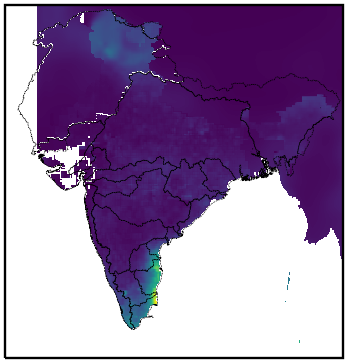

In [19]:
dss=ds['TotalPrecip_tavg'].mean(dim='year').compute()
dss=dss.where(((dss['lon']<79) | (dss['lon']>85)) | ((dss['lat']>10)))

fig, axs = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(5,5),constrained_layout=False)


# Step 3 : Figure axis confiureations   
fig.subplots_adjust(bottom=None, left=None, top=None, right=0.8, wspace=0.03, hspace=0.13) 
[x.set_linewidth(1.7) for x in axs.spines.values()]
axs.set_extent([64.90, 98,5.5, 37.50], ccrs.PlateCarree())

# Step 5 : Plotting the data
basin_map = gpd.read_file('DATA_p/Shapefiles/Indian_basin/India_transboundary.shp')
Main_plot=dss.plot(ax=axs,add_labels=False,add_colorbar=False) 
basin_map.plot(ax=axs,color = 'none',edgecolor = 'black',linewidth=.4,linestyle='--')

## 2_REGIONAL

In [5]:
import pymannkendall as mk
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import scienceplots

mdl=5
ss=1
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc","LIS_IMDcnew"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE','RE_cleaned']
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]

ds_RM = xr.open_mfdataset(f'DATA_p/LIS/{model[mdl]}/{model[mdl]}_reg_ssn.nc',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
basin=ds_RM.region.values
ds_RM


var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE','RE_cleaned']


fig, ax = plt.subplots(5,4,figsize=(18,11), facecolor='white', dpi=600,sharey=True,sharex=True)
ax1=ax.flatten()

ax2=[ax1[i].twinx() for i in range(len(ax1))]

for i in range(18):

    plt.style.use(['science','no-latex','bright'])
    
    ds_RM1=ds_RM.isel(season=ss)
    
    yr=ds_RM1.year
    re=ds_RM1['RE'].isel(region=i)
    ppt=ds_RM1['TotalPrecip_tavg'].isel(region=i)
    #qs=ds_RM1['Qs_tavg'].isel(region=i)

    [x.set_linewidth(1.25) for x in ax1[i].spines.values()]
    ax1[i].grid(True, color= 'grey', alpha=0.4, linestyle='dotted')
    #plt.xticks(np.arange(1980, 2020+1, 5.0))
    
    lw=1.2;al=1

    
    ax1[i].plot(yr, re, color='black', label='Runoff Efficiency', alpha=al, linewidth=lw*1.2)
    
    ax2[i].plot(yr, ppt, color='darkblue', label='Precipitation', alpha=0.8, linewidth=0.6)
    #ax2.set_ylabel('Precipitation', fontsize=12, color='red')  # Set the label for the right y-axis
    #ax2.tick_params(axis='y', labelcolor='red')
   
    
    ax1[i].xaxis.set_tick_params(which='both', bottom=True, top=False,labelsize=17)
    ax1[i].yaxis.set_tick_params(which='both', left=True, right=False,labelsize=17)
    ax1[i].set_ylim(0,0.45)

    ax2[i].xaxis.set_tick_params(which='both', bottom=True, top=False,labelsize=17)
    ax2[i].yaxis.set_tick_params(which='both', left=True, right=False,labelsize=17)
    ax2[i].set_ylim(0,850)


    
    re_var=re.std().compute().values
    ppt_var=ppt.std().compute().values
    ax1[i].text(0.43, 0.97,f"RE:{re_var.round(3)}", fontsize=15.5, color='Black',ha='left', va='top', transform=ax1[i].transAxes)
    ax1[i].text(0.75, 0.97,f"P:{ppt_var.round(2)}", fontsize=15.5, color='Black',ha='left', va='top', transform=ax1[i].transAxes)

    
    #ax1[i].set_title(f'{basin[i]}', fontsize=20) 
    ax1[i].text(0.05, 0.97, f'{basin[i]}', fontsize=16, weight='bold', ha='left', va='top', transform=ax1[i].transAxes)
    
    
    fig.suptitle(f'{model[mdl]} ({ssn[ss]})', fontsize=17,fontweight='bold')

# Common xlabel and ylab
fig.text(0.5, -0.02, 'Year', ha='center', fontsize=23,fontweight='bold')
fig.text(-0.02, 0.5, 'Runoff efficiency', va='center', rotation='vertical', fontsize=23, fontweight='bold')
fig.text(1.02, 0.5, 'Precipitation', va='center', rotation='vertical', fontsize=23, fontweight='bold')
fig.suptitle(f'{ssn[ss]}', fontsize=25,fontweight='bold',y=1)

# Create a common legend
handles1, labels1 = ax1[0].get_legend_handles_labels()
handles2, labels2 = ax2[0].get_legend_handles_labels()
handles=handles1+handles2
labels=labels1+labels2
fig.legend(handles, labels, loc='upper center', ncol=1, fontsize=15, bbox_to_anchor=(0.6, 0.15), frameon=True, borderpad=0.5, edgecolor='black')



[ax1[i].axis('off') for i in range(18, 20)]
[ax2[i].axis('off') for i in range(18, 20)]

plt.tight_layout()
plt.savefig(f'2_RE analysis/1_mean_var/outputs/RE_P_var_{ssn[ss]}.png',dpi=600)
plt.show()

# FUNCTIONS

In [6]:
## Single map function
def Map_plot1(xrr1,fig,axs,plt_tit,cbar_tit):
    import numpy as np 
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import geopandas as gpd
    import matplotlib
    import xarray as xr
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.colors as clr
    import scienceplots
    
    plt.style.use(['science','no-latex','bright'])
    vmin1=xrr1.quantile(0.05)
    vmax1=xrr1.quantile(0.9)
    cmap1='viridis_r'
    
# Step 3 : Figure axis confiureations   
    fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.2, hspace=None) 
    [x.set_linewidth(1.5) for x in axs.spines.values()]
    axs.set_extent([67.90, 97,5, 37.50], ccrs.PlateCarree())

    fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.15, hspace=None)  

# Step 5 : Plotting the data
    basin_map = gpd.read_file('DATA_p/Shapefiles/Indian_basin/India_transboundary.shp')
    #ind_map = gpd.read_file('DATA/Shapefiles/Indian_map/India_country.shp')
    Main_plot=xrr1.plot(vmin=vmin1,vmax=vmax1,ax=axs,cmap=cmap1,add_labels=False,add_colorbar=False) 
    basin_map.plot(ax=axs,color = 'none',edgecolor = 'white',linewidth=.4,linestyle='--')
    
    axs.set_title(plt_tit,fontsize=15,pad=8,fontname='Times New Roman',weight='bold')
    
# Step 4: Colourbar settings   

    #cbar_ax = fig.add_axes([lf+wd*0.51, bt + 0.026, wd-wd*0.6, 0.005])
    cbar=plt.colorbar(Main_plot, orientation="vertical",shrink=0.28, pad=.045, aspect=20, label = cbar_tit) #,label = cbar_tit
    cbar.outline.set_linewidth(1.1) 
    cbar.ax.tick_params(axis='both',which='both', labelsize=10,width=0.8, length=6) 
    cbar.ax.tick_params(axis='both',which='minor', labelsize=10,width=0.3, length=3)
    cbar.ax.tick_params(axis='both', labelsize=13) 

    cbar.ax.yaxis.labelpad = 10
    cbar.ax.yaxis.label.set_fontsize(16)
    cbar.ax.yaxis.label.set_fontweight('bold')
    cbar.ax.yaxis.label.set_fontname('Times New Roman')

    #cbar.set_label(cbar_tit, fontsize=wd*45, labelpad=-wd*130,weight="bold")#position=(0.5, -0.5)
    
    cbar.locator = ticker.MaxNLocator(nbins=6)  # You can adjust the number of bins as needed
    cbar.update_ticks()

In [5]:
def Map_plot2(xrr,col_row,plt_tit,cbar_tit):

    import numpy as np 
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import geopandas as gpd
    import matplotlib
    import xarray as xr
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.colors as clr
    import scienceplots
    c=col_row[1]
    r=col_row[0]
    # Define the parameters
    B=5   # THis is the base scale. one figure dimension. All are determined based on this

    bt = 1.5  # bottom space
    
    fig_len=c*5 
    fig_hg=r*5.2 +bt   #This 1.15 depend on the subplot dimension. This case, height of subplot more than length
    fnt = B*3.2
    pd = B*1.5
    ln_wd = B*0.2
    
    fig, axs = plt.subplots(col_row[0],col_row[1],subplot_kw={'projection': ccrs.PlateCarree()},figsize=(fig_len,fig_hg),constrained_layout=False)
    axs=axs.flatten()

    #Adding feature maps
    basin_map = gpd.read_file('DATA_p/Shapefiles/Indian_basin/India_transboundary.shp')
    ind_map = gpd.read_file('DATA_p/Shapefiles/Indian_map/India_country.shp')

    #define plot variables
    vmin1 =xrr[0].quantile(0.05)
    vmax1=xrr[0].quantile(0.9)
    #vmin1 =0
    #vmax1=0.016
    cmap2='RdBu'

    #Loop over all of the models
    for i,model in enumerate(range(len(xrr))):

            # Axis setttings
            data=xrr[i]

            axs[i].set_extent([67.90, 97.59,4.5, 37.50], ccrs.PlateCarree())

            axs[i].set_xticks([72,80,88], crs=ccrs.PlateCarree())
            axs[i].set_yticks([10,20,30], crs=ccrs.PlateCarree())
            axs[i].xaxis.set_ticks_position('bottom')
            axs[i].yaxis.set_ticks_position('left')
            axs[i].tick_params(axis='both', labelrotation=90,pad=1,labelsize=7,width=1.2, length=6)
            axs[i].set_xticklabels([])
            axs[i].set_yticklabels([])
            [x.set_linewidth(2) for x in axs[i].spines.values()]        #bOUNDARY WIDTHH 

            #cmap1 = clr.LinearSegmentedColormap.from_list('blue_to_white', ['lightgrey', '#FFFFFF'], N=256)
            #gradient = np.linspace(0, 1, 256).reshape(-1, 1)
            #axs[i].imshow(gradient, cmap=cmap1, extent=[67.90, 97.59,4.5, 37.50], transform=ccrs.PlateCarree())    

            axs[i].set_title(f"{plt_tit[i]}",fontsize=fnt,pad=pd,fontname='Times New Roman',weight='bold')

            # Customize gridlines (NOTE CARTOPY WONT PROVIDE TICKS, SO WE MANUALLY PROVIDED IN ABOVE LINE)
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.05, color='black', alpha=0.2, linestyle='-')

            gl.xlabel_style = {"size" : 13,'family': 'Times New Roman','weight': 'normal','rotation': 0}
            gl.ylabel_style = {"size" : 13,'family': 'Times New Roman','weight': 'normal','rotation': 90}
            gl.top_labels = False
            gl.right_labels = False
            gl.xlocator = plt.MaxNLocator(4)  # Adjust the number of x-axis gridlines as needed
            gl.ylocator = plt.MaxNLocator(4) 


            # Adding Mainplo
            Main_plot=data.plot(vmin=vmin1,vmax=vmax1 ,ax=axs[i], cmap=cmap2, add_labels=False, add_colorbar=False) 

            # Adding addition feature 
            basin_map.plot(ax=axs[i],color = 'none',edgecolor = 'black',linewidth=ln_wd,linestyle='--')



    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=1.5/fig_hg, left=None, top=None, right=None, wspace=1.6/fig_len, hspace=2/fig_hg)  # First lock bottom, while make others None (automatically select), Then change spaces

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.63/fig_hg, 0.6, 0.19/fig_hg])   # left,bottom, widht, height

    # Draw the colorbar
    cbar=fig.colorbar(Main_plot, cax=cbar_ax,orientation='horizontal') #,ticks=[0, 1,5]
    cbar.outline.set_linewidth(2) 
    cbar.ax.tick_params(axis='both',which='both', labelsize=fnt,width=2, length=8) 
    cbar.ax.tick_params(axis='both',which='minor', labelsize=fnt*0.7,width=1, length=4) 
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    cbar.set_label(cbar_tit, fontsize=fnt*1.2, labelpad=-55,weight="bold")#position=(0.5, -0.5)
    cbar.ax.xaxis.label.set_fontweight('bold')

    fig.suptitle("", fontsize=19, y=0.915, fontweight='bold', fontname='Times New Roman')
    

In [8]:
## Single map function
def Map_plot3(xrr,col_row,V,plt_tit,cbar_tit):
    import numpy as np 
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import geopandas as gpd
    import matplotlib.pyplot as plt
    import xarray as xr
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.colors as clr
    import matplotlib.ticker as ticker
    import scienceplots
    plt.style.use(['science','no-latex','bright'])
    
    c=col_row[1]
    r=col_row[0]
    B=5
    lt = 0  # bottom space
    fig_len=c*5 + lt
    fig_hg=r*5.3
    fnt = B*3.2
    pd = B*1.5
    ln_wd = B*0.2
    
    fig, axs = plt.subplots(r,c,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(fig_len,fig_hg),constrained_layout=False)
    axs=axs.flatten()

    acron=['a','b','c','d','e','f','g','h']

    for i in range(len(xrr)):    

        Kwarg = {
        'cmap': 'viridis_r',
        'vmin': V[i][0],    # Minimum value for the colormap
        'vmax': V[i][1],     # Maximum value for the colormap
        'alpha': 1,  # Transparency
         }
        
        # Step 3 : Figure axis confiureations   
        fig.subplots_adjust(bottom=None, left=None, top=None, right=0.8, wspace=0.03, hspace=0.13) 
        [x.set_linewidth(1.7) for x in axs[i].spines.values()]
        axs[i].set_extent([67.90, 97,5.5, 37.50], ccrs.PlateCarree())
    
        lf=axs[i].get_position().x0
        bt=axs[i].get_position().y0
        wd=axs[i].get_position().width
        hg=axs[i].get_position().height
    
        # Step 5 : Plotting the data
        basin_map = gpd.read_file('DATA_p/Shapefiles/Indian_basin/India_transboundary.shp')
        Main_plot=xrr[i].plot(ax=axs[i],**Kwarg,add_labels=False,add_colorbar=False) 
        basin_map.plot(ax=axs[i],color = 'none',edgecolor = 'black',linewidth=.4,linestyle='--')
        
        axs[i].set_title(f"{acron[i]}) {plt_tit[i]}",fontsize=B*4,pad=1.8*B,fontname='Times New Roman',weight='bold')
        
        # Step 4: Colourbar settings   
        if (i+1) % 4 == 0:  # Check if a is a multiple of 4
            cbar_ax = fig.add_axes([lf+wd+0.005, bt+0.02 , 0.008, hg-0.2*hg])
            cbar=plt.colorbar(Main_plot,cax=cbar_ax, orientation="vertical",extend='neither',shrink=0.9, pad=.06, aspect=20) #,label = cbar_tit
            cbar.set_label(cbar_tit[i], fontsize=B*4.2, labelpad=B*3.2)#position=(0.5, -0.5)
            
            cbar.ax.tick_params(axis='both',which='both', labelsize=16,width=0.8, length=5) 
            cbar.ax.tick_params(axis='both',which='minor', labelsize=16,width=0.2, length=3)
            cbar.ax.tick_params(axis='both', labelsize=16) 
            
            cbar.outline.set_linewidth(1) 
            cbar.ax.yaxis.label.set_fontname('Times New Roman')
           # cbar.ax.yaxis.label.set_fontweight('bold')

            cbar.locator = ticker.MaxNLocator(nbins=6)  # You can adjust the number of bins as needed
            cbar.update_ticks()
            
        print(wd)
